https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset

# Load data

In [1]:
!if [ ! -d movielens-20m-dataset ]; then kaggle datasets download -d grouplens/movielens-20m-dataset; fi

!if [ -f movielens-20m-dataset.zip ]; then unzip movielens-20m-dataset.zip; rm movielens-20m-dataset.zip; mkdir movielens-20m-dataset; mv *.csv movielens-20m-dataset/; fi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import sys
import shutil

import optuna

from tqdm.notebook import tqdm

from sklearn.utils import shuffle

from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark import SparkContext, SparkConf

import torch
import torch.nn as nn
import torch.nn.functional as F

plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
df = pd.read_csv('movielens-20m-dataset/rating.csv', parse_dates=['timestamp'])
df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 610.4 MB


Create sequential IDs for users and movies, that begin at 0. This is needed by some models. Original IDs are sparse.

In [5]:
df['userIdseq'] = pd.Categorical(df['userId'])
df['userIdseq'] = df['userIdseq'].cat.codes
df['movieIdseq'] = pd.Categorical(df['movieId'])
df['movieIdseq'] = df['movieIdseq'].cat.codes
df

,userId,movieId,rating,timestamp,userIdseq,movieIdseq
0,1,2,3.5,2005-04-02 23:53:47,0,1
1,1,29,3.5,2005-04-02 23:31:16,0,28
2,1,32,3.5,2005-04-02 23:33:39,0,31
3,1,47,3.5,2005-04-02 23:32:07,0,46
4,1,50,3.5,2005-04-02 23:29:40,0,49
...,...,...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00,138492,13754
20000259,138493,69526,4.5,2009-12-03 18:31:48,138492,13862
20000260,138493,69644,3.0,2009-12-07 18:10:57,138492,13875
20000261,138493,70286,5.0,2009-11-13 15:42:24,138492,13993


In [6]:
df.sort_values(by=['timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,userId,movieId,rating,timestamp,userIdseq,movieIdseq
0,28507,1176,4.0,1995-01-09 11:46:44,28506,1153
1,131160,1079,3.0,1995-01-09 11:46:49,131159,1057
2,131160,47,5.0,1995-01-09 11:46:49,131159,46
3,131160,21,3.0,1995-01-09 11:46:49,131159,20
4,85252,45,3.0,1996-01-29 00:00:00,85251,44
...,...,...,...,...,...,...
20000258,53930,118706,3.5,2015-03-31 06:00:51,53929,24832
20000259,16978,2093,3.5,2015-03-31 06:03:17,16977,2009
20000260,89081,55232,3.5,2015-03-31 06:11:26,89080,12118
20000261,89081,52458,4.0,2015-03-31 06:11:28,89080,11782


Create translation dictionaries from sequential IDs back to original IDs. Models operate in sequential ID space. Results must be brought back into the original ID space.

In [7]:
user_idseq2id = df[['userId', 'userIdseq']].drop_duplicates(
    subset=['userIdseq']
)
movie_idseq2id = df[['movieId', 'movieIdseq']].drop_duplicates(
    subset=['movieIdseq']
)
user_idseq2id = pd.Series(
    user_idseq2id['userId'].values, index=user_idseq2id['userIdseq']
).to_dict()
movie_idseq2id = pd.Series(
    movie_idseq2id['movieId'].values, index=movie_idseq2id['movieIdseq']
).to_dict()

In [8]:
N = len(set(df['userIdseq'].unique().tolist()))
M = len(set(df['movieIdseq'].unique().tolist()))
N_ratings = len(df)

print(f'nr. of users:        {N:,}')
print(f'nr. of movies:       {M:,}')
print(f'nr. of observations: {N_ratings:,}')

nr. of users:        138,493
nr. of movies:       26,744
nr. of observations: 20,000,263


Train/test split. Use a calendar date for the split.

In [9]:
train_1st_day = '2014-01-01'

df_train = df.loc[df['timestamp'] < train_1st_day]
df_test = df.loc[df['timestamp'] >= train_1st_day]

df_seq_train_fn = 'movielens-20m-dataset/rating-seq-train.csv'
df_seq_test_fn = 'movielens-20m-dataset/rating-seq-test.csv'

if not os.path.isfile(df_seq_train_fn):
    df_train.to_csv(df_seq_train_fn, index=False)
if not os.path.isfile(df_seq_test_fn):
    df_test.to_csv(df_seq_test_fn, index=False)

In [10]:
user_ids_train = df_train['userIdseq'].values
movie_ids_train = df_train['movieIdseq'].values
ratings_train = df_train['rating'].values / df['rating'].max()

user_ids_test = df_test['userIdseq'].values
movie_ids_test = df_test['movieIdseq'].values
ratings_test = df_test['rating'].values / df['rating'].max()

train_fraq = len(user_ids_train) / len(df)

print(f'nr. of observations training:   {len(user_ids_train):,}')
print(f'nr. of observations testing:    {len(user_ids_test):,}')
print(f'training set size / total size: {train_fraq}')

nr. of observations training:   19,153,489
nr. of observations testing:    846,774
training set size / total size: 0.9576618567465838


Load additional info about movies. Not used by the models (for now).

In [11]:
movie_df = pd.read_csv('movielens-20m-dataset/movie.csv', index_col='movieId')
movie_df

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
131254,Kein Bund für's Leben (2007),Comedy
131256,"Feuer, Eis & Dosenbier (2002)",Comedy
131258,The Pirates (2014),Adventure


# PyTorch

Main model definition.

In [12]:
class RSModel(nn.Module):
    def __init__(
        self,
        n_users,
        n_items,
        embed_dim=20,
        n_hidden1=20,
        n_hidden2=20,
        activation='sigmoid',
    ):
        super(RSModel, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.activation = activation

        self.emb_users = nn.Embedding(self.N, self.D)
        self.emb_items = nn.Embedding(self.M, self.D)

        """
        # set the weights since N(0, 1) leads to poor results
        self.emb_users.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D_users) * 0.01))
        self.emb_items.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.M, self.D_items) * 0.01))
        """

        self.fc1 = nn.Linear(2 * self.D, self.n_hidden1)
        self.fc2 = nn.Linear(self.n_hidden1, self.n_hidden2)
        self.fc_out = nn.Linear(self.n_hidden2, 1)

    def forward(self, u, b):
        u = self.emb_users(u)
        b = self.emb_items(b)
        out = torch.cat((u, b), 1)

        out = self.fc1(out)
        if self.activation == 'relu':
            out = F.relu(out)
        elif self.activation == 'leaky_relu':
            out = F.leaky_relu(out)
        elif self.activation == 'sigmoid':
            out = F.sigmoid(out)
        elif self.activation == 'tanh':
            out = F.tanh(out)
        else:
            raise Exception(f'unknown activation {self.activation}')

        out = self.fc2(out)
        if self.activation == 'relu':
            out = F.relu(out)
        elif self.activation == 'leaky_relu':
            out = F.leaky_relu(out)
        elif self.activation == 'sigmoid':
            out = F.sigmoid(out)
        elif self.activation == 'tanh':
            out = F.tanh(out)
        else:
            raise Exception(f'unknown activation {self.activation}')

        out = self.fc_out(out)
        return out

Gradient descent function.

In [13]:
def batch_gd_direct(
    model,
    device,
    criterion,
    optimizer,
    train_tuple,
    test_tuple,
    epochs=24,
    batch_size=512,
    progress=True,
    quit_after=5,
):
    # Using a torch dataloader is slower than using tensors directly
    # so we use tensors here.
    # First, extract the numpy arrays:
    user_ids_train, movie_ids_train, ratings_train = train_tuple
    user_ids_test, movie_ids_test, ratings_test = test_tuple

    losses_train = np.full(epochs, np.inf)
    losses_test = np.full(epochs, np.inf)

    batches_per_epoch_train = int(np.ceil(len(user_ids_train) / batch_size))
    batches_per_epoch_test = int(np.ceil(len(user_ids_test) / batch_size))

    for it in range(epochs):
        t_start = datetime.now()
        loss_train = []

        # shuffle train data
        user_ids_train, movie_ids_train, ratings_train = shuffle(
            user_ids_train, movie_ids_train, ratings_train, random_state=it
        )

        for j in range(batches_per_epoch_train):
            # create batch
            users_batch = user_ids_train[j * batch_size : (j + 1) * batch_size]
            movies_batch = movie_ids_train[
                j * batch_size : (j + 1) * batch_size
            ]
            ratings_batch = ratings_train[j * batch_size : (j + 1) * batch_size]

            # convert to tensor
            users_batch = torch.from_numpy(users_batch).long()
            movies_batch = torch.from_numpy(movies_batch).long()
            ratings_batch = torch.from_numpy(ratings_batch)
            # reshape targets
            ratings_batch = ratings_batch.view(-1, 1).float()

            # move batch to GPU
            users_batch, movies_batch, ratings_batch = (
                users_batch.to(device),
                movies_batch.to(device),
                ratings_batch.to(device),
            )

            # forward pass
            optimizer.zero_grad()
            outputs = model(users_batch, movies_batch)
            loss = criterion(outputs, ratings_batch)

            # backward pass
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())

        losses_train[it] = np.mean(loss_train)

        loss_test = []

        for j in range(batches_per_epoch_test):
            # create batch
            users_batch = user_ids_test[j * batch_size : (j + 1) * batch_size]
            movies_batch = movie_ids_test[j * batch_size : (j + 1) * batch_size]
            ratings_batch = ratings_test[j * batch_size : (j + 1) * batch_size]

            # convert to tensor
            users_batch = torch.from_numpy(users_batch).long()
            movies_batch = torch.from_numpy(movies_batch).long()
            ratings_batch = torch.from_numpy(ratings_batch)
            # reshape targets
            ratings_batch = ratings_batch.view(-1, 1).float()

            # move batch to GPU
            users_batch, movies_batch, ratings_batch = (
                users_batch.to(device),
                movies_batch.to(device),
                ratings_batch.to(device),
            )

            outputs = model(users_batch, movies_batch)
            loss = criterion(outputs, ratings_batch)
            loss_test.append(loss.item())

        losses_test[it] = np.mean(loss_test)

        dt = datetime.now() - t_start
        if progress:
            print(
                f'epoch: {(1+it):3n}/{epochs}, train loss: {losses_train[it]:.8f}, test loss: {losses_test[it]:.8f}, duration: {dt}'
            )
        best_epoch = np.argmin(losses_test)
        if best_epoch == it:
            torch.save(model.state_dict(), 'torch_recsys.pt')
        if it - best_epoch >= quit_after:
            break

    return losses_train[: it + 1], losses_test[: it + 1]

Create and evaluate a model, given some parameters. Should probably be merged in the objective function below.

In [14]:
def evaluate_torch(
    device,
    train_tuple,
    test_tuple,
    N,
    M,
    D=20,
    H1=20,
    H2=20,
    activation='sigmoid',
    lr_sgd=0.03,
    momentum=0.9,
    epochs=24,
    progress=False,
    quit_after=5,
):

    torch.manual_seed(0)
    model = RSModel(N, M, D, H1, H2, activation)
    model.to(device)

    criterion = nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr_sgd, momentum=momentum
    )

    batch_size = 512

    losses_train, losses_test = batch_gd_direct(
        model,
        device,
        criterion,
        optimizer,
        train_tuple,
        test_tuple,
        epochs,
        batch_size,
        progress,
        quit_after,
    )
    return losses_test.min()

Optuna objective function.

In [15]:
def objective_torch(trial, device, train_tuple, test_tuple, N, M):
    D = trial.suggest_int('D_embedding', 2, 1000, step=1, log=True)
    H1 = trial.suggest_int(f'Hidden1', 2, 10000, step=1, log=True)
    H2 = trial.suggest_int(f'Hidden2', 2, 10000, step=1, log=True)
    activation = trial.suggest_categorical(
        'activation', ['relu', 'leaky_relu', 'sigmoid', 'tanh']
    )
    lr_sgd = trial.suggest_float('lr_sgd', 0.00001, 0.01, log=True)
    momentum = trial.suggest_float('momentum', 0.5, 0.999, log=True)

    loss = evaluate_torch(
        device,
        train_tuple,
        test_tuple,
        N,
        M,
        D=D,
        H1=H1,
        H2=H2,
        activation=activation,
        lr_sgd=lr_sgd,
        momentum=momentum,
        epochs=24,
        progress=False,
        quit_after=5,
    )
    torch.cuda.empty_cache()
    return loss

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display(device)

device(type='cuda', index=0)

In [17]:
study_torch = optuna.create_study(
    storage='sqlite:///optuna_recsys_torch.db',
    sampler=optuna.samplers.TPESampler(n_startup_trials=10, seed=0),
    study_name='Movie Lens 20m',
    direction='minimize',
    load_if_exists=True,
)

[I 2024-02-19 12:42:02,588] Using an existing study with name 'Movie Lens 20m' instead of creating a new one.


Hyperparameter optimization.

In [18]:
best_pytorch_model = 'torch_recsys_best.pt'

if False:
    # if optimization is run, assume the best model will become obsolete
    #
    # TODO: not the best strategy. Model management should be handled in an Optuna hook,
    # so training the best model again would not be needed.
    try:
        os.remove(best_pytorch_model)
    except Exception as e:
        pass
    study_torch.optimize(
        lambda trial: objective_torch(
            trial,
            device,
            (user_ids_train, movie_ids_train, ratings_train),
            (user_ids_test, movie_ids_test, ratings_test),
            N,
            M,
        ),
        n_trials=None,
        timeout=9 * 3600,
        n_jobs=1,
        gc_after_trial=True,
        show_progress_bar=True,
    )

In [19]:
study_torch.best_params

{'D_embedding': 71,
 'Hidden1': 245,
 'Hidden2': 259,
 'activation': 'leaky_relu',
 'lr_sgd': 0.0007657998731223536,
 'momentum': 0.997086550671604}

In [20]:
study_torch.best_value

0.038680934534152514

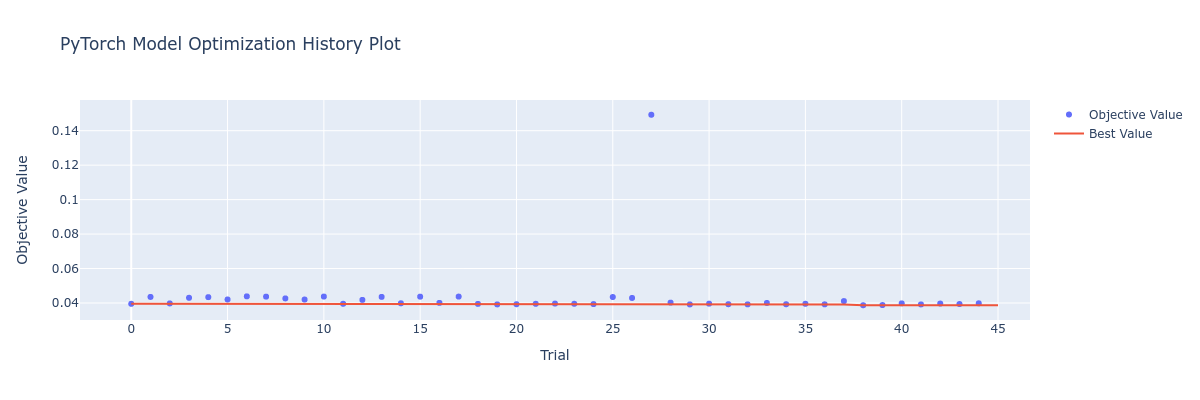

In [21]:
fig = optuna.visualization.plot_optimization_history(study_torch)
fig.update_layout(
    title='PyTorch Model Optimization History Plot', width=1200, height=400
)
fig.show('png')

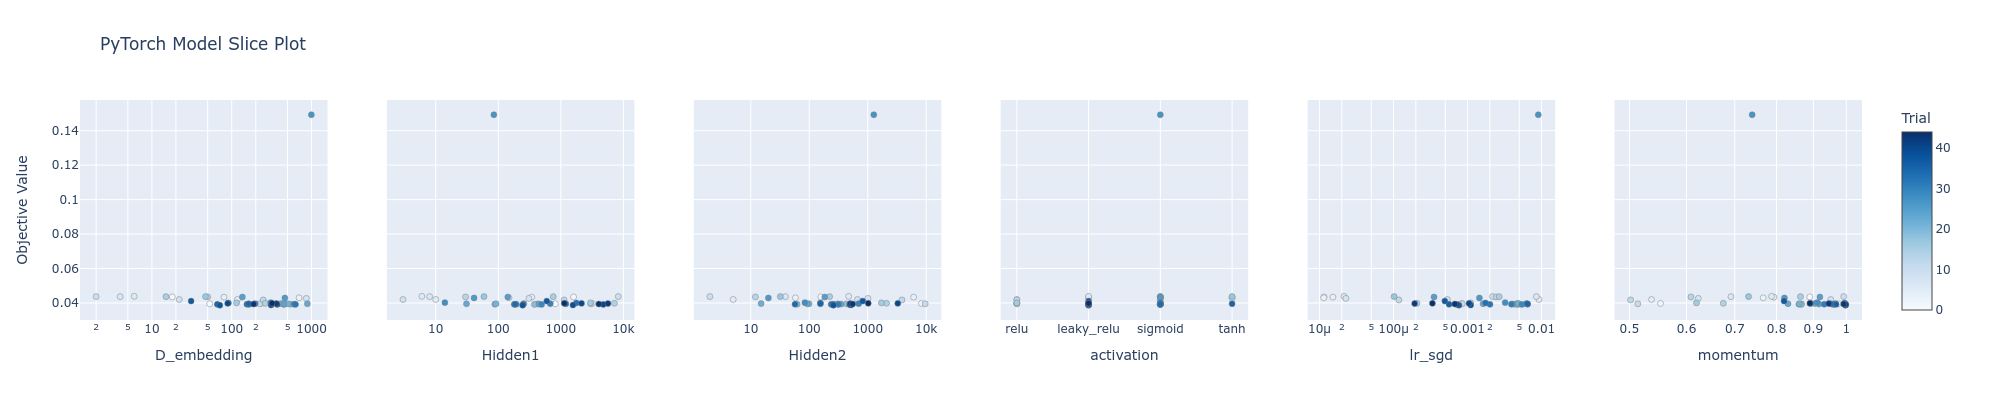

In [22]:
fig = optuna.visualization.plot_slice(study_torch)
fig.update_layout(title='PyTorch Model Slice Plot', width=2000, height=400)
fig.show('png')

# Spark

Create Spark context and train/test RDDs. Train model. Evaluate its performance on test data. Return performance.

In [23]:
def evaluate_spark(
    df_seq_train_fn, df_seq_test_fn, K=10, epochs=10, lambda_=0.01
):
    # set python executables
    os.environ['PYSPARK_PYTHON'] = sys.executable
    os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

    # Memory and multiprocessing are fine-tuned for 64 GB RAM single system
    #
    # increase memory
    SparkContext.setSystemProperty('spark.driver.memory', '40g')
    # SparkContext.setSystemProperty('spark.executor.memory', '40g')
    SparkContext.setSystemProperty('spark.memory.fraction', '0.8')
    # create context
    # local[...] controls the number of multiprocessing workers
    # local[*] = use all CPUs
    sc = SparkContext("local[3]", "Movie Lens 20m")

    # load and extract data
    data_train = sc.textFile(df_seq_train_fn)
    header_train = data_train.first()
    data_train = data_train.filter(lambda row: row != header_train)

    data_test = sc.textFile(df_seq_test_fn)
    header_test = data_test.first()
    data_test = data_test.filter(lambda row: row != header_test)

    ratings_train = data_train.map(lambda l: l.split(',')).map(
        lambda l: Rating(int(l[4]), int(l[5]), float(l[2]))
    )
    ratings_test = data_test.map(lambda l: l.split(',')).map(
        lambda l: Rating(int(l[4]), int(l[5]), float(l[2]))
    )

    # train model
    model = ALS.train(
        ratings=ratings_train,
        rank=K,
        iterations=epochs,
        lambda_=lambda_,
        seed=0,
    )

    # evaluate model
    # extract test features
    x = ratings_test.map(lambda p: (p[0], p[1]))
    # make predictions
    p = model.predictAll(x).map(lambda r: ((r[0], r[1]), r[2]))
    # join with ground-truth labels
    ratesAndPreds = ratings_test.map(lambda r: ((r[0], r[1]), r[2])).join(p)
    # compute MSE
    # divide by 5 to keep the same [0, 1] scale like the other models
    mse = ratesAndPreds.map(lambda r: (r[1][0] / 5 - r[1][1] / 5) ** 2).mean()
    # force evaluation
    mse = mse * 1.0

    sc.stop()
    return mse

Optuna objective function.

In [24]:
def objective_spark(trial, df_seq_train_fn, df_seq_test_fn, epochs=10):
    rank = trial.suggest_int('rank', 1, 100, step=1, log=True)
    lambda_ = trial.suggest_float('lambda', 0.005, 0.5, log=True)

    loss = evaluate_spark(
        df_seq_train_fn, df_seq_test_fn, rank, epochs, lambda_
    )
    return loss

Hyperparameter optimization.

In [25]:
study_spark = optuna.create_study(
    storage='sqlite:///optuna_recsys_spark.db',
    sampler=optuna.samplers.TPESampler(n_startup_trials=20, seed=0),
    study_name='Movie Lens 20m',
    direction='minimize',
    load_if_exists=True,
)

[I 2024-02-19 12:42:04,457] Using an existing study with name 'Movie Lens 20m' instead of creating a new one.


In [26]:
best_spark_model = 'spark_recsys_best'

if False:
    # if optimization is run, assume the best model will become obsolete
    shutil.rmtree(best_spark_model, ignore_errors=True)
    study_spark.optimize(
        lambda trial: objective_spark(
            trial, df_seq_train_fn, df_seq_test_fn, epochs=10
        ),
        n_trials=None,
        timeout=1.5 * 3600,
        n_jobs=1,
        gc_after_trial=True,
        show_progress_bar=True,
    )

In [27]:
study_spark.best_params

{'rank': 19, 'lambda': 0.07607513547547576}

In [28]:
study_spark.best_value

0.02614118493694747

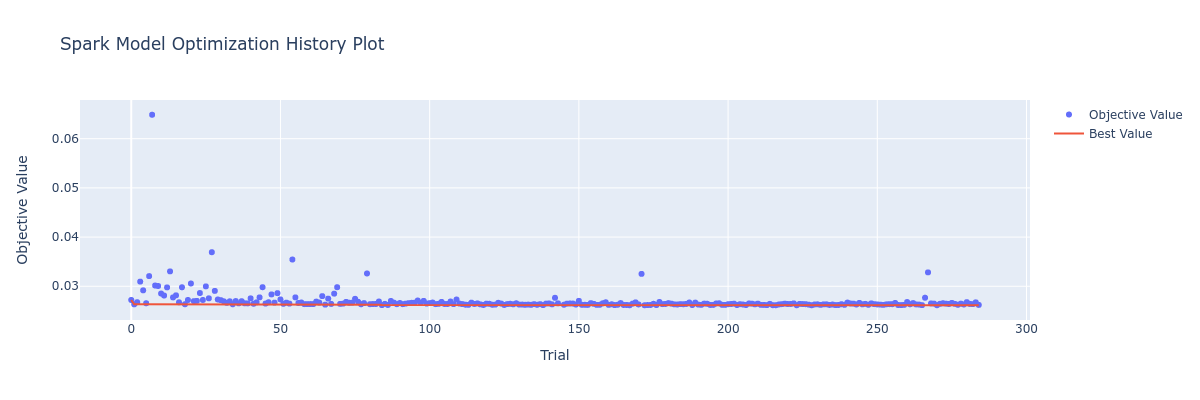

In [29]:
fig = optuna.visualization.plot_optimization_history(study_spark)
fig.update_layout(
    title='Spark Model Optimization History Plot', width=1200, height=400
)
fig.show('png')

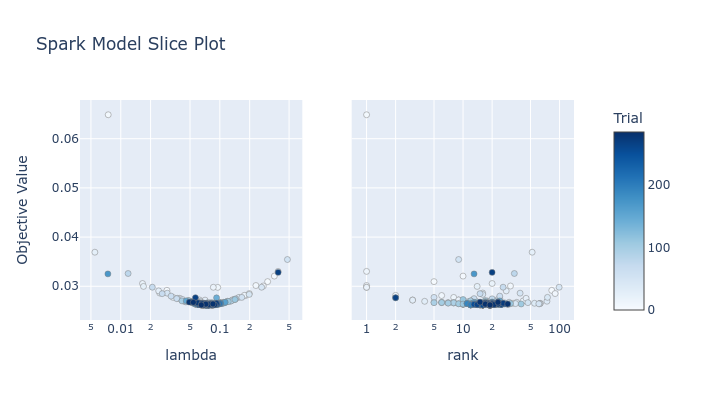

In [30]:
fig = optuna.visualization.plot_slice(study_spark)
fig.update_layout(title='Spark Model Slice Plot', width=720, height=400)
fig.show('png')

# Make recommendations

Use the best models, determined above, to make movie recommendations for a given user.

## Prepare data

Take a user ID, find the movies they have watched.

Then find all the movies they have not watched - these will be used to run predictions (make recommendations).

In [31]:
n_entry = 0
userId = df['userId'].to_list()[n_entry]
userIdseq = df['userIdseq'].to_list()[n_entry]
movies_watched = df[df['userId'] == userId]['movieIdseq'].unique()

movies_unwatched = df[~df['movieIdseq'].isin(movies_watched)][
    'movieIdseq'
].unique()
user_ids_np = np.full(movies_unwatched.shape[0], userIdseq)

n_rec = 30
print(f'Top {n_rec} rated movies by user {userId}:')
top_rated = (
    df[df['userId'] == userId][['movieId', 'rating']]
    .sort_values(by='rating', ascending=False)
    .join(movie_df, on='movieId')
    .head(n_rec)
)
top_rated

Top 30 rated movies by user 28507:


,movieId,rating,title,genres
1632701,720,5.0,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
1939379,1446,5.0,Kolya (Kolja) (1996),Comedy|Drama
1637326,541,5.0,Blade Runner (1982),Action|Sci-Fi|Thriller
1606103,36,5.0,Dead Man Walking (1995),Crime|Drama
1606115,745,5.0,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy
1632709,1148,5.0,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime
1606163,1366,5.0,"Crucible, The (1996)",Drama
1632713,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1632696,290,5.0,Once Were Warriors (1994),Crime|Drama
1632694,527,5.0,Schindler's List (1993),Drama|War


## PyTorch

Either load the best model if it exists, or train one from scratch using the best hyperparameters.

In [32]:
torch.manual_seed(0)
model_torch = RSModel(
    N,
    M,
    study_torch.best_params['D_embedding'],
    study_torch.best_params['Hidden1'],
    study_torch.best_params['Hidden2'],
    study_torch.best_params['activation'],
)

if not os.path.isfile(best_pytorch_model):
    print('Best model not found, need to train it first.')
    model_torch.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(
        model_torch.parameters(),
        lr=study_torch.best_params['lr_sgd'],
        momentum=study_torch.best_params['momentum'],
    )
    _ = batch_gd_direct(
        model_torch,
        device,
        criterion,
        optimizer,
        (user_ids_train, movie_ids_train, ratings_train),
        (user_ids_test, movie_ids_test, ratings_test),
    )
    shutil.copy('torch_recsys.pt', best_pytorch_model)
else:
    print(f'Found best trained model {best_pytorch_model}, loading it now.')
    model_torch.load_state_dict(torch.load(best_pytorch_model))
    model_torch.to(device)

Found best trained model torch_recsys_best.pt, loading it now.


Run predictions on movies not watched by the user.

In [33]:
user_ids_batch = torch.from_numpy(user_ids_np).long().to(device)
movie_ids_batch = torch.from_numpy(movies_unwatched).long().to(device)

with torch.no_grad():
    pred_t = model_torch(user_ids_batch, movie_ids_batch)
predictions = pred_t.cpu().numpy().flatten() * df['rating'].max()

sort_idx = np.argsort(-predictions)
recommendations_torch = pd.DataFrame(
    {
        'movieId': [movie_idseq2id[id] for id in movies_unwatched[sort_idx]],
        'rating_pred': predictions[sort_idx].tolist(),
    }
)
recommendations_torch = recommendations_torch.join(movie_df, on='movieId')
print(f'Top {n_rec} recommendations for userId {userId}:')
recommendations_torch.head(n_rec)

Top 30 recommendations for userId 28507:


,movieId,rating_pred,title,genres
0,103380,4.835875,A Coming-Out Party (1961),Comedy|Drama
1,90084,4.598035,"Experience, The (Tadjrebeh) (1973)",Drama
2,124077,4.583772,The Trip to Bountiful (2014),Drama
3,126921,4.531214,The Fox and the Hound 2 (2006),Adventure|Animation|Children|Comedy
4,90843,4.530509,Lavatory Lovestory (Ubornaya istoriya - lyubov...,Animation
5,113306,4.520823,"Dragon Missile, The (Fei long zhan) (1976)",Action
6,99748,4.483615,I Got Next (2011),Documentary
7,77816,4.462348,"Lord, Save Us from Your Followers (2008)",Documentary
8,101801,4.457100,"Skylab, Le (2011)",Comedy|Drama
9,111789,4.452935,Gulliver's Travels (1977),Adventure|Animation


In [34]:
del model_torch
torch.cuda.empty_cache()

## Spark

Either load the best model if it exists, or train one from scratch using the best hyperparameters.

In [35]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
sc = SparkContext("local[3]", "Movie Lens 20m")

if not os.path.isdir(best_spark_model):
    print('Best model not found, need to train it first.')
    data_train = sc.textFile(df_seq_train_fn)
    header_train = data_train.first()
    data_train = data_train.filter(lambda row: row != header_train)
    ratings_train = data_train.map(lambda l: l.split(',')).map(
        lambda l: Rating(int(l[4]), int(l[5]), float(l[2]))
    )

    model_spark = ALS.train(
        ratings=ratings_train,
        rank=study_spark.best_params['rank'],
        iterations=10,
        lambda_=study_spark.best_params['lambda'],
        seed=0,
    )
    model_spark.save(sc, best_spark_model)
else:
    print(f'Found best trained model {best_spark_model}, loading it now.')
    model_spark = MatrixFactorizationModel.load(sc, best_spark_model)

/usr/lib/python3.11/subprocess.py:1883: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

24/02/19 12:42:08 WARN Utils: Your hostname, media resolves to a loopback address: 127.0.1.1; using 192.168.1.20 instead (on interface enp39s0)
24/02/19 12:42:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/19 12:42:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Found best trained model spark_recsys_best, loading it now.


24/02/19 12:42:11 WARN MatrixFactorizationModel: User factor does not have a partitioner. Prediction on individual records could be slow.
24/02/19 12:42:11 WARN MatrixFactorizationModel: User factor is not cached. Prediction could be slow.
24/02/19 12:42:11 WARN MatrixFactorizationModel: Product factor does not have a partitioner. Prediction on individual records could be slow.
24/02/19 12:42:11 WARN MatrixFactorizationModel: Product factor is not cached. Prediction could be slow.
24/02/19 12:42:11 WARN MatrixFactorizationModelWrapper: User factor does not have a partitioner. Prediction on individual records could be slow.
24/02/19 12:42:11 WARN MatrixFactorizationModelWrapper: User factor is not cached. Prediction could be slow.
24/02/19 12:42:11 WARN MatrixFactorizationModelWrapper: Product factor does not have a partitioner. Prediction on individual records could be slow.
24/02/19 12:42:11 WARN MatrixFactorizationModelWrapper: Product factor is not cached. Prediction could be slow.


Run predictions on the movies not watched by the user.

In [36]:
user_movie_batch = sc.parallelize(
    zip(user_ids_np.tolist(), movies_unwatched.tolist())
)
out = model_spark.predictAll(user_movie_batch)
df_spark_pred = pd.DataFrame(
    out.map(lambda x: [x[1], x[2]]).collect(),
    columns=['movieId', 'rating_pred'],
)
df_spark_pred['movieId'] = df_spark_pred['movieId'].apply(
    lambda x: movie_idseq2id[x]
)
df_spark_pred.sort_values(by='rating_pred', ascending=False, inplace=True)
recommendations_spark = df_spark_pred.join(movie_df, on='movieId')

print(f'Top {n_rec} recommendations for userId {userId}:')
recommendations_spark.head(n_rec)

Top 30 recommendations for userId 28507:


,movieId,rating_pred,title,genres
13079,98595,5.042134,Peppermint Soda (Diabolo menthe) (1977),Comedy|Drama
8737,81117,4.913878,"Moth, The (Cma) (1980)",Drama
17473,106048,4.887680,Four Days in July (1985),Comedy|Drama
9015,99675,4.746409,Eat Sleep Die (Äta sova dö) (2012),Drama
12016,86237,4.648244,Connections (1978),Documentary
12487,81072,4.625854,Konopielka (1982),Comedy
3096,5814,4.582462,"Rising Place, The (2002)",Drama
4574,107408,4.565295,Only Old Men Are Going to Battle (V boy idut o...,Comedy|Drama|War
6810,72235,4.494393,Between the Devil and the Deep Blue Sea (1995),Drama
237,73365,4.468267,Dead Time: Kala (2007),Crime|Fantasy|Film-Noir|Thriller


In [37]:
del model_spark
sc.stop()
del sc

Partial overlap between PyTorch and Spark in terms of genres, but no overlap in terms of actual recommended movies.

Spark has much lower loss in testing, so its recommendations are likely better.